In [1]:
import sys,pandas as pd,matplotlib.pyplot as plt,numpy as np,itertools,plotly.offline as py
from datetime import datetime,timedelta
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from prophet.plot import add_changepoints_to_plot
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_forecast_component
from prophet.diagnostics import cross_validation,performance_metrics
from prophet.plot import (
      plot_plotly
     ,plot_components_plotly
     ,plot_forecast_component_plotly
     ,plot_seasonality_plotly
     ,plot_cross_validation_metric
      )

# Data prep

In [2]:
sales_sandro = pd.read_excel(r'/Users/dimitribouvier/Documents/FBProphet dfs/pivoted_sales_sandro.xlsx')
sales_maje = pd.read_excel(r'/Users/dimitribouvier/Documents/FBProphet dfs/pivoted_sales_maje.xlsx')
# stores_sandro = pd.read_excel(r'/Users/dimitribouvier/Documents/FBProphet dfs/storesOpenedOverTimesandro.xlsx').rename(columns={'Date':'JOURDEVENTE'})
# stores_sandro = stores_sandro[['numberOfStores','JOURDEVENTE']]
# stores_maje = pd.read_excel(r'/Users/dimitribouvier/Documents/FBProphet dfs/storesOpenedOverTimemaje.xlsx').rename(columns={'Date':'JOURDEVENTE'})
# stores_maje = stores_maje[['numberOfStores','JOURDEVENTE']]

discount_sandro = pd.read_excel(r"/Users/dimitribouvier/Documents/FBProphet dfs/sandro_discount_rate.xlsx").dropna(subset=['drate'])
discount_maje = pd.read_excel(r"/Users/dimitribouvier/Documents/FBProphet dfs/maje_discount_rate.xlsx").dropna(subset=['drate'])
discount_sandro=discount_sandro[(discount_sandro['drate']>0) & (discount_sandro['drate']<1)].reset_index(drop=True)
discount_maje=discount_maje[(discount_maje['drate']>0) & (discount_maje['drate']<1)].reset_index(drop=True)

for df in [sales_sandro,sales_maje,discount_sandro,discount_maje]:#,stores_maje,stores_sandro
    df['JOURDEVENTE'] = pd.Series(map(lambda x: datetime.strptime(df.iloc[x,1].strftime("%Y-%m"),'%Y-%m'),df.index))

def pivotization(df,index_field,values_field,function_field):
    return pd.pivot_table(data=df,
                        index=[index_field]
                        ,values=[values_field]
                        ,aggfunc=function_field) \
        .reset_index(drop=False) \
        .sort_values(by=['JOURDEVENTE'])
sales_sandro = pivotization(sales_sandro,'JOURDEVENTE','NUMTICKET','sum').iloc[:-1,:]
sales_maje = pivotization(sales_maje,'JOURDEVENTE','NUMTICKET','sum').iloc[:-1,:]
discount_sandro = pivotization(discount_sandro,'JOURDEVENTE','drate',np.mean)
discount_maje = pivotization(discount_maje,'JOURDEVENTE','drate',np.mean)
# stores_maje = pivotization(stores_maje,'JOURDEVENTE','numberOfStores',np.mean)
# stores_sandro = pivotization(stores_sandro,'JOURDEVENTE','numberOfStores',np.mean)


#merging the data with extra regressors
sales_sandro = sales_sandro.merge(right=discount_sandro
                                 ,how='left'
                                 ,on='JOURDEVENTE')
sales_maje = sales_maje.merge(right=discount_maje
                                 ,how='left'
                                 ,on='JOURDEVENTE')
# sales_sandro = sales_sandro.merge(right=stores_sandro
#                                  ,how='left'
#                                  ,on='JOURDEVENTE')
# sales_maje = sales_maje.merge(right=stores_maje
#                                  ,how='left'
#                                  ,on='JOURDEVENTE')

#adding cci and un into the mix
cci = pd.read_excel(r"/Users/dimitribouvier/Documents/FBProphet dfs/UMCSENT.xls").dropna(subset=['Unnamed: 1']).reset_index(drop=True).iloc[2:,:].reset_index(drop=True)
cci['FRED Graph Observations'] = pd.to_datetime(cci['FRED Graph Observations'])
cci['FRED Graph Observations'] = pd.Series(map(lambda x: datetime.strptime(cci.iloc[x,0].strftime("%Y-%m"),'%Y-%m'), cci.index))
cci.rename(columns={'FRED Graph Observations':'ds','Unnamed: 1':'cci'},inplace=True)
sales_maje = sales_maje.merge(right=cci,how='left',left_on='JOURDEVENTE',right_on='ds')
sales_sandro = sales_sandro.merge(right=cci,how='left',left_on='JOURDEVENTE',right_on='ds')
sales_maje.drop(columns=['ds'],inplace=True)
sales_sandro.drop(columns=['ds'],inplace=True)

unrate = pd.read_excel(r"/Users/dimitribouvier/Documents/FBProphet dfs/UNRATE.xls"
                       ,names=['JOURDEVENTE','un']).dropna(subset=['un']).iloc[2:,:].reset_index(drop=True)
unrate['JOURDEVENTE'] = pd.Series(map(lambda x: datetime.strptime(unrate.iloc[x,0].strftime("%Y-%m"),'%Y-%m'), unrate.index))
sales_maje = sales_maje.merge(right=unrate,on='JOURDEVENTE',how='left')
sales_sandro = sales_sandro.merge(right=unrate,on='JOURDEVENTE',how='left')

# dgorder = pd.read_excel(r"/Users/dimitribouvier/Documents/FBProphet dfs/DGORDER.xls"
#                        ,names=['JOURDEVENTE','dgorder']).dropna(subset=['dgorder']).iloc[2:,:].reset_index(drop=True)
# dgorder['JOURDEVENTE'] = pd.Series(map(lambda x: datetime.strptime(dgorder.iloc[x,0].strftime("%Y-%m"),'%Y-%m'), dgorder.index))
# sales_maje = sales_maje.merge(right=dgorder,on='JOURDEVENTE',how='left')
# sales_sandro = sales_sandro.merge(right=dgorder,on='JOURDEVENTE',how='left')

# fed = pd.read_excel(r"/Users/dimitribouvier/Documents/FBProphet dfs/DFF.xls"
#                     ,names=['JOURDEVENTE','fed']).dropna(subset=['fed']).iloc[2:,:].reset_index(drop=True)
# fed['JOURDEVENTE'] = pd.Series(map(lambda x: datetime.strptime(fed.iloc[x,0].strftime("%Y-%m"),'%Y-%m'), fed.index))
# fed = pd.pivot_table(data=fed,index=['JOURDEVENTE'],values=['fed'],aggfunc=np.mean).reset_index(drop=False)
# sales_maje = sales_maje.merge(right=fed,on='JOURDEVENTE',how='left')
# sales_sandro = sales_sandro.merge(right=fed,on='JOURDEVENTE',how='left')

# labor = pd.read_excel(r"/Users/dimitribouvier/Documents/FBProphet dfs/CIVPART.xls"
#                     ,names=['JOURDEVENTE','part']).dropna(subset=['part']).iloc[2:,:].reset_index(drop=True)
# labor['JOURDEVENTE'] = pd.Series(map(lambda x: datetime.strptime(labor.iloc[x,0].strftime("%Y-%m"),'%Y-%m'), labor.index))
# sales_maje = sales_maje.merge(right=labor,on='JOURDEVENTE',how='left')
# sales_sandro = sales_sandro.merge(right=labor,on='JOURDEVENTE',how='left')

#duplicating the discount rate and the cci of the last 12 months 12 months into the future
next_year = sales_sandro.iloc[-12:,:].reset_index(drop=True)
next_year['JOURDEVENTE'] = pd.Series(map(lambda x: next_year.iloc[x,0]+timedelta(days=365),next_year.index))
sales_sandro = pd.concat([sales_sandro,next_year]).reset_index(drop=True)
next_year = sales_maje.iloc[-12:,:].reset_index(drop=True)
next_year['JOURDEVENTE'] = pd.Series(map(lambda x: next_year.iloc[x,0]+timedelta(days=365),next_year.index))
sales_maje = pd.concat([sales_maje,next_year]).reset_index(drop=True)
sales_maje.iloc[-12:,1] = np.nan
sales_sandro.iloc[-12:,1] = np.nan

#filtering out dates
sales_sandro = sales_sandro[(sales_sandro['JOURDEVENTE']<'2020-01-01') | (sales_sandro['JOURDEVENTE']>='2021-04-01')].reset_index(drop=True)
sales_maje = sales_maje[(sales_maje['JOURDEVENTE']<'2020-01-01') | (sales_maje['JOURDEVENTE']>='2021-04-01')].reset_index(drop=True)
# sales_sandro = sales_sandro[sales_sandro['JOURDEVENTE']>='2016-01-01'].reset_index(drop=True)
# sales_maje = sales_maje[sales_maje['JOURDEVENTE']>='2016-01-01'].reset_index(drop=True)

#making the dfs Prophet-ready
sales_sandro.rename(columns={'JOURDEVENTE':'ds'
                            ,'NUMTICKET':'y'},inplace=True)
sales_maje.rename(columns={'JOURDEVENTE':'ds'
                            ,'NUMTICKET':'y'},inplace=True)
sales_sandro['drate'] = sales_sandro['drate']*100
sales_maje['drate'] = sales_maje['drate']*100

for col in ['cci','un','dgorder','part']:
    try:
        sales_sandro[col] = pd.to_numeric(sales_sandro[col])
        sales_maje[col] = pd.to_numeric(sales_maje[col])
    except:
        pass
    

no_regressor = False
if no_regressor == True:
    sales_sandro = sales_sandro.iloc[:,:2]
    sales_maje = sales_maje.iloc[:,:2]


In [3]:
sales_maje


ds       y      drate   cci   un
0   2012-01-01  2357.0  68.450385  75.0  8.3
1   2012-02-01  1919.0  62.806191  75.3  8.3
2   2012-03-01  1785.0  20.391741  76.2  8.2
3   2012-04-01  2806.0   9.287389  76.4  8.2
4   2012-05-01  3729.0  31.933298  79.3  8.2
..         ...     ...        ...   ...  ...
122 2023-06-01     NaN  35.060687  50.0  3.6
123 2023-07-01     NaN  52.472704  51.5  3.5
124 2023-08-01     NaN  59.629837  58.2  3.7
125 2023-09-01     NaN  34.417456  58.6  3.5
126 2023-10-01     NaN  32.368633  59.9  3.7

[127 rows x 5 columns]

In [4]:
sales_maje.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      127 non-null    datetime64[ns]
 1   y       115 non-null    float64       
 2   drate   127 non-null    float64       
 3   cci     127 non-null    float64       
 4   un      127 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 5.1 KB


# EDA

In [5]:
import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.express as px
from plotly import tools
hist_data = [np.array(sales_sandro['drate'])
             ,np.array(sales_maje['drate'])]
group_labels = ['Sandro','Maje']
fig = ff.create_distplot(hist_data
                       ,group_labels
                        ,bin_size=[1,1]
                       )
fig.show()

In [6]:
sandro_trace = go.Heatmap(z=sales_sandro.corr()
                         ,zmin=-1,zmax=1
                         ,texttemplate="%{z:.2f}"
                         ,x=['Sales Volume'
                             ,'Discount Rate'
                             ,'Consumer Sentiment'
                             ,'Unemployment Rate'
                            ]
                         ,y=['Sales Volume'
                             ,'Discount Rate'
                             ,'Consumer Sentiment'
                             ,'Unemployment Rate'
                            ]
                         )
maje_trace = go.Heatmap(z=sales_maje.corr()
                         ,zmin=-1,zmax=1
                         ,texttemplate="%{z:.2f}"
                       ,x=['Sales Volume'
                           ,'Discount Rate'
                           ,'Consumer Sentiment'
                           ,'Unemployment Rate'
                          ]
                       ,y=['Sales Volume'
                           ,'Discount Rate'
                           ,'Consumer Sentiment'
                           ,'Unemployment Rate'
                          ]
                       )
fig = tools.make_subplots(rows=1,cols=2
                        ,subplot_titles=['Sandro'
                                        ,'Maje']
                         ,shared_yaxes=True)
fig.append_trace(sandro_trace,1,1)
fig.append_trace(maje_trace,1,2)
fig.update_layout(title='Pearson Correlation matrices',title_x=0.5)
fig.show()

/Users/dimitribouvier/opt/anaconda3/lib/python3.9/site-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [7]:
sales_sandro.corr()

y     drate       cci        un
y      1.000000  0.324440  0.092109 -0.774518
drate  0.324440  1.000000  0.184571 -0.006730
cci    0.092109  0.184571  1.000000 -0.054258
un    -0.774518 -0.006730 -0.054258  1.000000

# Prophet

15:37:49 - cmdstanpy - INFO - Chain [1] start processing
15:37:49 - cmdstanpy - INFO - Chain [1] done processing
15:37:52 - cmdstanpy - INFO - Chain [1] start processing
15:37:52 - cmdstanpy - INFO - Chain [1] start processing
15:37:52 - cmdstanpy - INFO - Chain [1] start processing
15:37:52 - cmdstanpy - INFO - Chain [1] start processing
15:37:52 - cmdstanpy - INFO - Chain [1] start processing
15:37:52 - cmdstanpy - INFO - Chain [1] start processing
15:37:52 - cmdstanpy - INFO - Chain [1] start processing
15:37:52 - cmdstanpy - INFO - Chain [1] start processing
15:37:53 - cmdstanpy - INFO - Chain [1] done processing
15:37:53 - cmdstanpy - INFO - Chain [1] done processing
15:37:53 - cmdstanpy - INFO - Chain [1] done processing
15:37:53 - cmdstanpy - INFO - Chain [1] done processing
15:37:53 - cmdstanpy - INFO - Chain [1] done processing
15:37:53 - cmdstanpy - INFO - Chain [1] start processing
15:37:53 - cmdstanpy - INFO - Chain [1] start processing
15:37:53 - cmdstanpy - INFO - Chain [

15:38:01 - cmdstanpy - INFO - Chain [1] start processing
15:38:01 - cmdstanpy - INFO - Chain [1] done processing
15:38:04 - cmdstanpy - INFO - Chain [1] start processing
15:38:04 - cmdstanpy - INFO - Chain [1] start processing
15:38:04 - cmdstanpy - INFO - Chain [1] start processing
15:38:04 - cmdstanpy - INFO - Chain [1] start processing
15:38:04 - cmdstanpy - INFO - Chain [1] start processing
15:38:04 - cmdstanpy - INFO - Chain [1] start processing
15:38:04 - cmdstanpy - INFO - Chain [1] start processing
15:38:04 - cmdstanpy - INFO - Chain [1] start processing
15:38:04 - cmdstanpy - INFO - Chain [1] done processing
15:38:04 - cmdstanpy - INFO - Chain [1] done processing
15:38:04 - cmdstanpy - INFO - Chain [1] done processing
15:38:04 - cmdstanpy - INFO - Chain [1] done processing
15:38:04 - cmdstanpy - INFO - Chain [1] done processing
15:38:04 - cmdstanpy - INFO - Chain [1] done processing
15:38:05 - cmdstanpy - INFO - Chain [1] start processing
15:38:05 - cmdstanpy - INFO - Chain [1

15:38:13 - cmdstanpy - INFO - Chain [1] done processing
15:38:13 - cmdstanpy - INFO - Chain [1] start processing
15:38:13 - cmdstanpy - INFO - Chain [1] done processing
15:38:13 - cmdstanpy - INFO - Chain [1] start processing
15:38:13 - cmdstanpy - INFO - Chain [1] done processing
15:38:16 - cmdstanpy - INFO - Chain [1] start processing
15:38:16 - cmdstanpy - INFO - Chain [1] start processing
15:38:16 - cmdstanpy - INFO - Chain [1] start processing
15:38:16 - cmdstanpy - INFO - Chain [1] start processing
15:38:16 - cmdstanpy - INFO - Chain [1] start processing
15:38:16 - cmdstanpy - INFO - Chain [1] start processing
15:38:16 - cmdstanpy - INFO - Chain [1] start processing
15:38:16 - cmdstanpy - INFO - Chain [1] start processing
15:38:17 - cmdstanpy - INFO - Chain [1] done processing
15:38:17 - cmdstanpy - INFO - Chain [1] done processing
15:38:17 - cmdstanpy - INFO - Chain [1] done processing
15:38:17 - cmdstanpy - INFO - Chain [1] done processing
15:38:17 - cmdstanpy - INFO - Chain [1

15:38:25 - cmdstanpy - INFO - Chain [1] start processing
15:38:26 - cmdstanpy - INFO - Chain [1] done processing
15:38:26 - cmdstanpy - INFO - Chain [1] done processing
15:38:26 - cmdstanpy - INFO - Chain [1] start processing
15:38:26 - cmdstanpy - INFO - Chain [1] done processing
15:38:29 - cmdstanpy - INFO - Chain [1] start processing
15:38:29 - cmdstanpy - INFO - Chain [1] start processing
15:38:29 - cmdstanpy - INFO - Chain [1] start processing
15:38:29 - cmdstanpy - INFO - Chain [1] start processing
15:38:29 - cmdstanpy - INFO - Chain [1] start processing
15:38:29 - cmdstanpy - INFO - Chain [1] start processing
15:38:29 - cmdstanpy - INFO - Chain [1] start processing
15:38:29 - cmdstanpy - INFO - Chain [1] start processing
15:38:30 - cmdstanpy - INFO - Chain [1] done processing
15:38:30 - cmdstanpy - INFO - Chain [1] done processing
15:38:30 - cmdstanpy - INFO - Chain [1] done processing
15:38:30 - cmdstanpy - INFO - Chain [1] done processing
15:38:30 - cmdstanpy - INFO - Chain [1

15:38:39 - cmdstanpy - INFO - Chain [1] start processing
15:38:39 - cmdstanpy - INFO - Chain [1] done processing
15:38:39 - cmdstanpy - INFO - Chain [1] done processing
15:38:39 - cmdstanpy - INFO - Chain [1] done processing
15:38:39 - cmdstanpy - INFO - Chain [1] start processing
15:38:39 - cmdstanpy - INFO - Chain [1] done processing
15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] done processing
15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] done processing
15:38:43 - cmdstanpy - INFO - Chain [1] done processing
15:38:43 - cmdstanpy - INFO - Chain [1

15:38:51 - cmdstanpy - INFO - Chain [1] start processing
15:38:51 - cmdstanpy - INFO - Chain [1] start processing
15:38:51 - cmdstanpy - INFO - Chain [1] done processing
15:38:51 - cmdstanpy - INFO - Chain [1] done processing
15:38:51 - cmdstanpy - INFO - Chain [1] start processing
15:38:52 - cmdstanpy - INFO - Chain [1] done processing
15:38:55 - cmdstanpy - INFO - Chain [1] start processing
15:38:55 - cmdstanpy - INFO - Chain [1] start processing
15:38:55 - cmdstanpy - INFO - Chain [1] start processing
15:38:55 - cmdstanpy - INFO - Chain [1] start processing
15:38:55 - cmdstanpy - INFO - Chain [1] start processing
15:38:55 - cmdstanpy - INFO - Chain [1] start processing
15:38:55 - cmdstanpy - INFO - Chain [1] start processing
15:38:55 - cmdstanpy - INFO - Chain [1] start processing
15:38:55 - cmdstanpy - INFO - Chain [1] done processing
15:38:55 - cmdstanpy - INFO - Chain [1] done processing
15:38:55 - cmdstanpy - INFO - Chain [1] done processing
15:38:55 - cmdstanpy - INFO - Chain [

15:39:02 - cmdstanpy - INFO - Chain [1] start processing
15:39:03 - cmdstanpy - INFO - Chain [1] done processing
15:39:03 - cmdstanpy - INFO - Chain [1] start processing
15:39:03 - cmdstanpy - INFO - Chain [1] done processing
15:39:06 - cmdstanpy - INFO - Chain [1] start processing
15:39:06 - cmdstanpy - INFO - Chain [1] start processing
15:39:06 - cmdstanpy - INFO - Chain [1] start processing
15:39:06 - cmdstanpy - INFO - Chain [1] start processing
15:39:06 - cmdstanpy - INFO - Chain [1] start processing
15:39:06 - cmdstanpy - INFO - Chain [1] start processing
15:39:06 - cmdstanpy - INFO - Chain [1] start processing
15:39:06 - cmdstanpy - INFO - Chain [1] start processing
15:39:06 - cmdstanpy - INFO - Chain [1] done processing
15:39:07 - cmdstanpy - INFO - Chain [1] done processing
15:39:07 - cmdstanpy - INFO - Chain [1] done processing
15:39:07 - cmdstanpy - INFO - Chain [1] done processing
15:39:07 - cmdstanpy - INFO - Chain [1] done processing
15:39:07 - cmdstanpy - INFO - Chain [1

15:39:14 - cmdstanpy - INFO - Chain [1] done processing
15:39:14 - cmdstanpy - INFO - Chain [1] done processing
15:39:14 - cmdstanpy - INFO - Chain [1] done processing
15:39:14 - cmdstanpy - INFO - Chain [1] start processing
15:39:14 - cmdstanpy - INFO - Chain [1] done processing
15:39:18 - cmdstanpy - INFO - Chain [1] start processing
15:39:18 - cmdstanpy - INFO - Chain [1] start processing
15:39:18 - cmdstanpy - INFO - Chain [1] done processing
15:39:18 - cmdstanpy - INFO - Chain [1] start processing
15:39:18 - cmdstanpy - INFO - Chain [1] start processing
15:39:18 - cmdstanpy - INFO - Chain [1] start processing
15:39:18 - cmdstanpy - INFO - Chain [1] start processing
15:39:18 - cmdstanpy - INFO - Chain [1] start processing
15:39:18 - cmdstanpy - INFO - Chain [1] done processing
15:39:18 - cmdstanpy - INFO - Chain [1] done processing
15:39:18 - cmdstanpy - INFO - Chain [1] done processing
15:39:18 - cmdstanpy - INFO - Chain [1] start processing
15:39:18 - cmdstanpy - INFO - Chain [1]

15:39:25 - cmdstanpy - INFO - Chain [1] start processing
15:39:25 - cmdstanpy - INFO - Chain [1] done processing
15:39:26 - cmdstanpy - INFO - Chain [1] done processing
15:39:26 - cmdstanpy - INFO - Chain [1] start processing
15:39:26 - cmdstanpy - INFO - Chain [1] done processing
15:39:29 - cmdstanpy - INFO - Chain [1] start processing
15:39:30 - cmdstanpy - INFO - Chain [1] start processing
15:39:30 - cmdstanpy - INFO - Chain [1] start processing
15:39:30 - cmdstanpy - INFO - Chain [1] start processing
15:39:30 - cmdstanpy - INFO - Chain [1] start processing
15:39:30 - cmdstanpy - INFO - Chain [1] start processing
15:39:30 - cmdstanpy - INFO - Chain [1] start processing
15:39:30 - cmdstanpy - INFO - Chain [1] start processing
15:39:30 - cmdstanpy - INFO - Chain [1] done processing
15:39:30 - cmdstanpy - INFO - Chain [1] done processing
15:39:30 - cmdstanpy - INFO - Chain [1] done processing
15:39:30 - cmdstanpy - INFO - Chain [1] done processing
15:39:30 - cmdstanpy - INFO - Chain [1

15:39:36 - cmdstanpy - INFO - Chain [1] start processing
15:39:36 - cmdstanpy - INFO - Chain [1] done processing
15:39:39 - cmdstanpy - INFO - Chain [1] start processing
15:39:39 - cmdstanpy - INFO - Chain [1] start processing
15:39:40 - cmdstanpy - INFO - Chain [1] start processing
15:39:40 - cmdstanpy - INFO - Chain [1] start processing
15:39:40 - cmdstanpy - INFO - Chain [1] start processing
15:39:40 - cmdstanpy - INFO - Chain [1] start processing
15:39:40 - cmdstanpy - INFO - Chain [1] done processing
15:39:40 - cmdstanpy - INFO - Chain [1] done processing
15:39:40 - cmdstanpy - INFO - Chain [1] done processing
15:39:40 - cmdstanpy - INFO - Chain [1] done processing
15:39:40 - cmdstanpy - INFO - Chain [1] done processing
15:39:40 - cmdstanpy - INFO - Chain [1] start processing
15:39:40 - cmdstanpy - INFO - Chain [1] done processing
15:39:40 - cmdstanpy - INFO - Chain [1] start processing
15:39:40 - cmdstanpy - INFO - Chain [1] done processing
15:39:40 - cmdstanpy - INFO - Chain [1]

15:39:46 - cmdstanpy - INFO - Chain [1] done processing
15:39:46 - cmdstanpy - INFO - Chain [1] start processing
15:39:46 - cmdstanpy - INFO - Chain [1] done processing
15:39:50 - cmdstanpy - INFO - Chain [1] start processing
15:39:50 - cmdstanpy - INFO - Chain [1] start processing
15:39:50 - cmdstanpy - INFO - Chain [1] start processing
15:39:50 - cmdstanpy - INFO - Chain [1] start processing
15:39:50 - cmdstanpy - INFO - Chain [1] start processing
15:39:50 - cmdstanpy - INFO - Chain [1] start processing
15:39:50 - cmdstanpy - INFO - Chain [1] done processing
15:39:50 - cmdstanpy - INFO - Chain [1] start processing
15:39:50 - cmdstanpy - INFO - Chain [1] done processing
15:39:50 - cmdstanpy - INFO - Chain [1] start processing
15:39:50 - cmdstanpy - INFO - Chain [1] done processing
15:39:50 - cmdstanpy - INFO - Chain [1] done processing
15:39:50 - cmdstanpy - INFO - Chain [1] done processing
15:39:50 - cmdstanpy - INFO - Chain [1] done processing
15:39:50 - cmdstanpy - INFO - Chain [1]

15:39:57 - cmdstanpy - INFO - Chain [1] start processing
15:39:57 - cmdstanpy - INFO - Chain [1] done processing
15:40:00 - cmdstanpy - INFO - Chain [1] start processing
15:40:00 - cmdstanpy - INFO - Chain [1] start processing
15:40:00 - cmdstanpy - INFO - Chain [1] start processing
15:40:00 - cmdstanpy - INFO - Chain [1] start processing
15:40:00 - cmdstanpy - INFO - Chain [1] start processing
15:40:00 - cmdstanpy - INFO - Chain [1] start processing
15:40:00 - cmdstanpy - INFO - Chain [1] start processing
15:40:00 - cmdstanpy - INFO - Chain [1] start processing
15:40:00 - cmdstanpy - INFO - Chain [1] done processing
15:40:00 - cmdstanpy - INFO - Chain [1] done processing
15:40:00 - cmdstanpy - INFO - Chain [1] done processing
15:40:00 - cmdstanpy - INFO - Chain [1] done processing
15:40:00 - cmdstanpy - INFO - Chain [1] done processing
15:40:00 - cmdstanpy - INFO - Chain [1] done processing
15:40:01 - cmdstanpy - INFO - Chain [1] done processing
15:40:01 - cmdstanpy - INFO - Chain [1]

15:40:06 - cmdstanpy - INFO - Chain [1] start processing
15:40:06 - cmdstanpy - INFO - Chain [1] done processing
15:40:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:40:06 - cmdstanpy - INFO - Chain [1] start processing
15:40:07 - cmdstanpy - INFO - Chain [1] done processing
15:40:10 - cmdstanpy - INFO - Chain [1] start processing
15:40:10 - cmdstanpy - INFO - Chain [1] start processing
15:40:10 - cmdstanpy - INFO - Chain [1] start processing
15:40:10 - cmdstanpy - INFO - Chain [1] start processing
15:40:10 - cmdstanpy - INFO - Chain [1] start processing
15:40:10 - cmdstanpy - INFO - Chain [1] start processing
15:40:10 - cmdstanpy - INFO - Chain [1] start processing
15:40:10 - cmdstanpy - INFO - Chain [1] done processing
15:40:10 - cmdstanpy - INFO - Chain [1] done processing
15:40:11 - cmdstanpy - INFO - Chain [1] start processing
15:40:11 - cmdstanpy - INFO - Chain [1] done process

15:40:18 - cmdstanpy - INFO - Chain [1] start processing
15:40:18 - cmdstanpy - INFO - Chain [1] done processing
15:40:18 - cmdstanpy - INFO - Chain [1] done processing
15:40:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:40:18 - cmdstanpy - INFO - Chain [1] start processing
15:40:18 - cmdstanpy - INFO - Chain [1] done processing
15:40:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:40:18 - cmdstanpy - INFO - Chain [1] done processing
15:40:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:40:18 - cmdstanpy - INFO - Chain [1] start processing
15:40:18 - cmdstanpy - INFO - Chain [1] start processing
15:40:18 - cmdstanpy - INFO - Chain [1] done processing
15:40:18 - cmdstanpy - INFO - 

15:40:30 - cmdstanpy - INFO - Chain [1] done processing
15:40:30 - cmdstanpy - INFO - Chain [1] start processing
15:40:30 - cmdstanpy - INFO - Chain [1] done processing
15:40:30 - cmdstanpy - INFO - Chain [1] done processing
15:40:30 - cmdstanpy - INFO - Chain [1] done processing
15:40:30 - cmdstanpy - INFO - Chain [1] done processing
15:40:30 - cmdstanpy - INFO - Chain [1] start processing
15:40:31 - cmdstanpy - INFO - Chain [1] done processing
15:40:31 - cmdstanpy - INFO - Chain [1] start processing
15:40:31 - cmdstanpy - INFO - Chain [1] start processing
15:40:31 - cmdstanpy - INFO - Chain [1] start processing
15:40:31 - cmdstanpy - INFO - Chain [1] done processing
15:40:31 - cmdstanpy - INFO - Chain [1] start processing
15:40:31 - cmdstanpy - INFO - Chain [1] start processing
15:40:31 - cmdstanpy - INFO - Chain [1] done processing
15:40:31 - cmdstanpy - INFO - Chain [1] done processing
15:40:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Opt

15:40:41 - cmdstanpy - INFO - Chain [1] done processing
15:40:42 - cmdstanpy - INFO - Chain [1] start processing
15:40:42 - cmdstanpy - INFO - Chain [1] start processing
15:40:42 - cmdstanpy - INFO - Chain [1] start processing
15:40:42 - cmdstanpy - INFO - Chain [1] start processing
15:40:42 - cmdstanpy - INFO - Chain [1] start processing
15:40:42 - cmdstanpy - INFO - Chain [1] done processing
15:40:42 - cmdstanpy - INFO - Chain [1] start processing
15:40:42 - cmdstanpy - INFO - Chain [1] start processing
15:40:42 - cmdstanpy - INFO - Chain [1] done processing
15:40:42 - cmdstanpy - INFO - Chain [1] done processing
15:40:42 - cmdstanpy - INFO - Chain [1] done processing
15:40:42 - cmdstanpy - INFO - Chain [1] start processing
15:40:42 - cmdstanpy - INFO - Chain [1] start processing
15:40:42 - cmdstanpy - INFO - Chain [1] start processing
15:40:42 - cmdstanpy - INFO - Chain [1] done processing
15:40:42 - cmdstanpy - INFO - Chain [1] done processing
15:40:42 - cmdstanpy - INFO - Chain [1

15:40:52 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing
15:40:53 - cmdstanpy - INFO - Chain [1] done processing
15:40:53 - cmdstanpy - INFO - Chain [1] done processing
15:40:53 - cmdstanpy - INFO - Chain [1] start processing
15:40:53 - cmdstanpy - INFO - Chain [1] start processing
15:40:53 - cmdstanpy - INFO - Chain [1] start processing
15:40:53 - cmdstanpy - INFO - Chain [1] start processing
15:40:53 - cmdstanpy - INFO - Chain [1] start processing
15:40:53 - cmdstanpy - INFO - Chain [1] done processing
15:40:53 - cmdstanpy - INFO - Chain [1] start processing
15:40:54 - cmdstanpy - INFO - Chain [

15:41:01 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
15:41:01 - cmdstanpy - INFO - CmdStan start processing


{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:41:03 - cmdstanpy - INFO - CmdStan done processing.
15:41:03 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


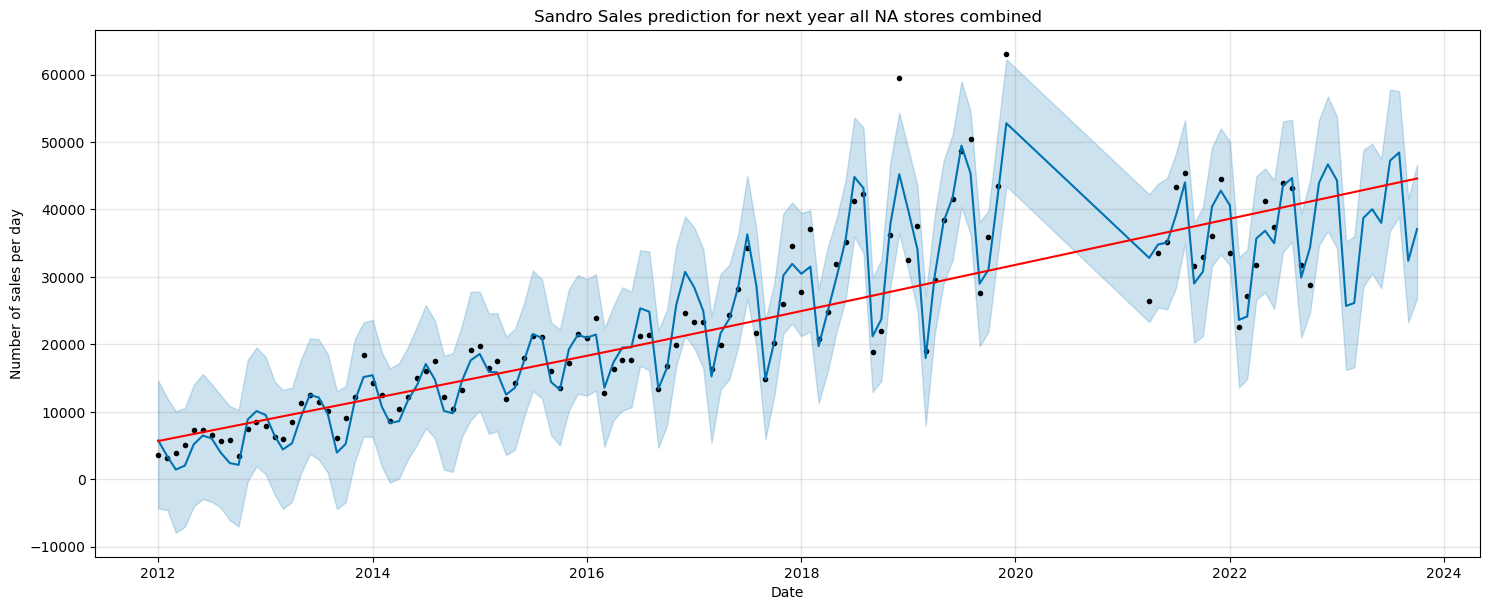

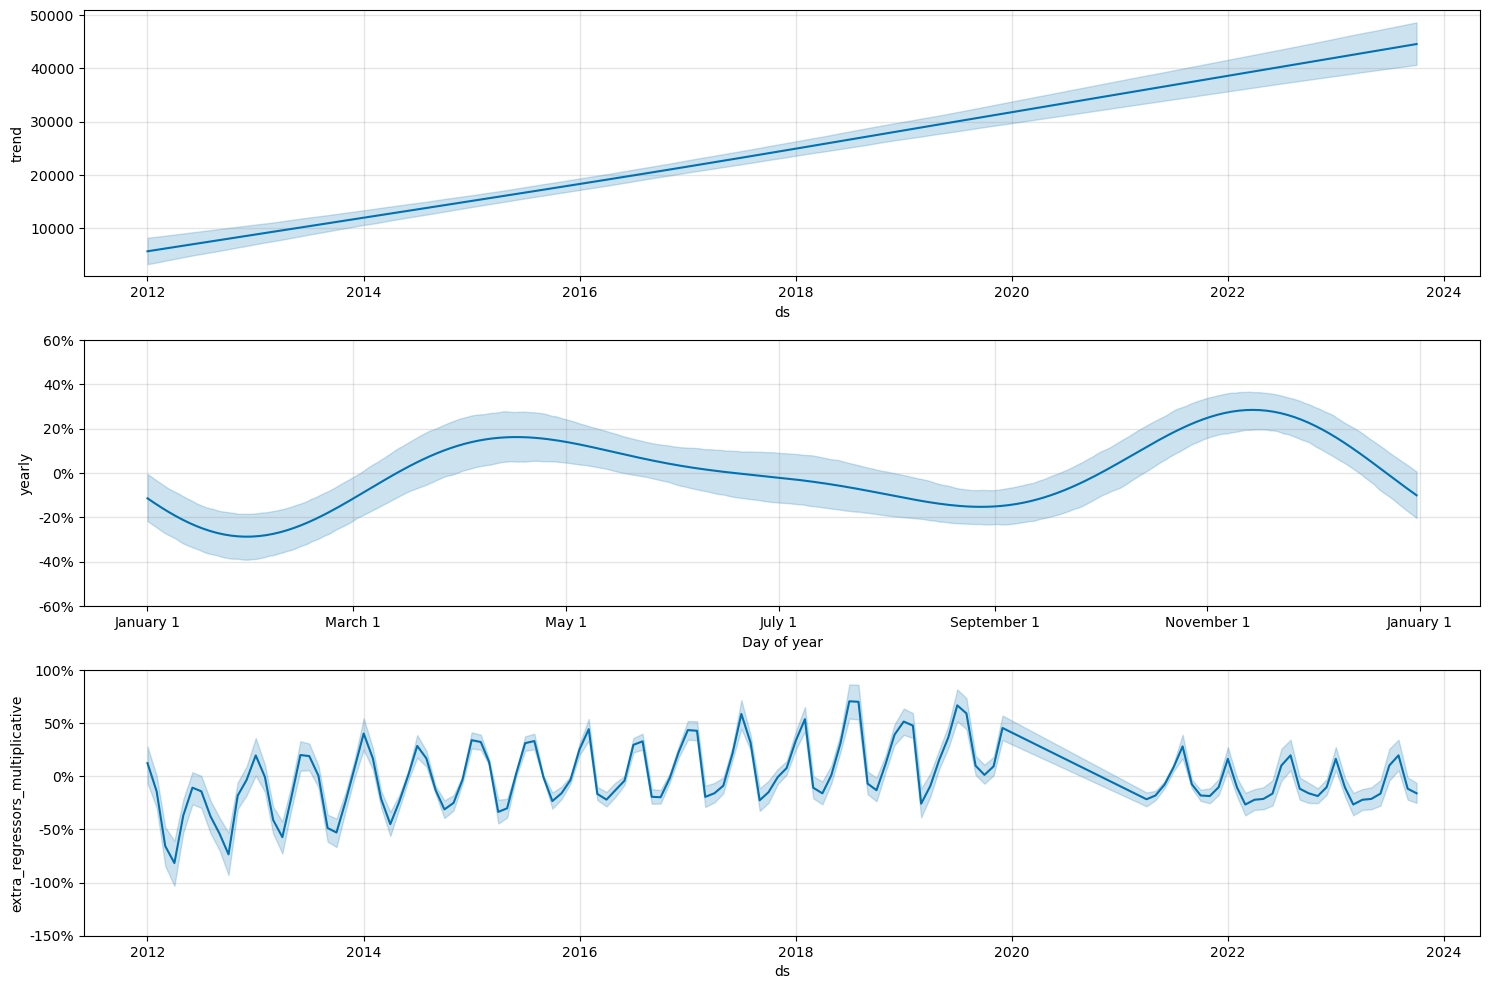

  regressor  regressor_mode     center  coef_lower      coef  coef_upper
0       cci  multiplicative  85.836522    0.000498  0.003442    0.006135
1     drate  multiplicative  41.755254    0.011210  0.015772    0.019721
2        un  multiplicative   5.272174   -0.122587 -0.071583   -0.020823


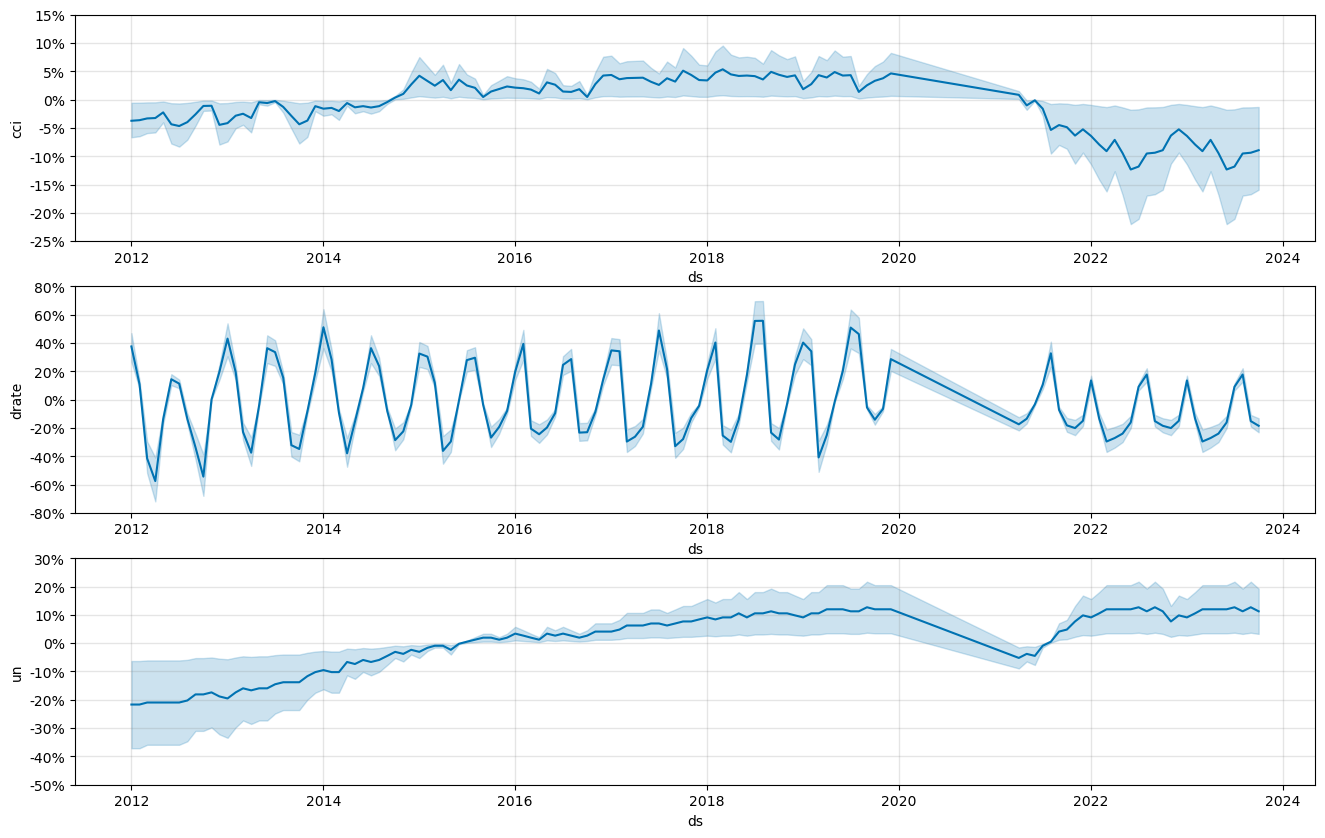

In [8]:
for brand,df in {'Sandro':sales_sandro}.items():#,'Maje':sales_maje}.items():
    y_axis_lim=None#(0,3000)
    x_axis_lim=None#['2016-01-01','2023-10-01']
    #---------------------------------------hyperparameters tuning-------------------------------------
    param_grid = {
                'changepoint_prior_scale': [0.5, 0.1, 0.01,0.001]
                 ,'seasonality_prior_scale': [10.0, 1.0, 0.1,0.01]
#                     ,'changepoint_range':[0.8,0.85,0.9,0.95]
#                  ,'holidays_prior_scale':[10,1,0.1,0.01]
#                  ,'seasonality_mode': ['additive','multiplicative']
    }
    all_params = [dict(zip(param_grid.keys(), value))
                  for value in itertools.product(
                        *param_grid.values())]
    rmse_values= []
    all_metrics_df = pd.DataFrame()
    for params in all_params:
        model = Prophet(
                    growth='linear'
                    ,seasonality_mode='multiplicative'
                    ,yearly_seasonality=3
#                     ,weekly_seasonality=3
                    ,interval_width=0.99
#                    ,uncertainty_samples=1000 if brand =='Sandro' else 10000
#                     ,mcmc_samples=30
                    ,**params
#                     ,holidays=holidays
                   )
        if no_regressor != True:
            model.add_regressor('cci')
            model.add_regressor('un')
            model.add_regressor('drate')
#             model.add_regressor('part')
#             model.add_regressor('dgorder')
#             model.add_regressor('fed')

        model.fit(df)
        df_cv = cross_validation(model
                    ,horizon='180 days'
                    ,period='30 days'
                    ,initial='1095 days'
                    ,parallel='processes')
        df_p = performance_metrics(df_cv, rolling_window=1)
        all_metrics_df = pd.concat([all_metrics_df,df_p])
        rmse_values.append(df_p['rmse'].values[0])
        #saves the all combinations results

    results = pd.DataFrame(all_params)
#     results['rmse'] = rmse_values
    for col in all_metrics_df:
        results[col] = all_metrics_df[col].to_list()
    best_params = all_params[np.argmin(rmse_values)]
    print(best_params)
    #-----------------------------------------instantiating the model---------------------------------------
    model = Prophet(
                    growth='linear'
                    ,seasonality_mode='multiplicative'
                    ,yearly_seasonality=3
#                     ,weekly_seasonality=3
#                     ,seasonality_prior_scale=10
#                     ,changepoint_prior_scale=0.05 if brand=='Sandro' else 0.05
                    ,interval_width=0.99
#                    ,uncertainty_samples=1000 if brand =='Sandro' else 10000
                    ,mcmc_samples=1000
                    ,**best_params
#                     ,holidays=holidays
                   )
    if no_regressor != True:
        model.add_regressor('cci')
        model.add_regressor('drate')
        model.add_regressor('un')
#         model.add_regressor('part')
#         model.add_regressor('dgorder')
#         model.add_regressor('fed')
    
    #-----------------------------------------fitting the model---------------------------------------
    model.fit(df)

    future = model.make_future_dataframe(periods=0 * 1)#dataset is already duplicated a year into the future
    if no_regressor != True:
        future['cci'] = df['cci']
        future['drate'] = df['drate']
        future['un'] = df['un']
#         future['part'] = df['part']
#         future['dgorder'] = df['dgorder']
#         future['fed'] = df['fed']
    future.fillna(0,inplace=True)
    forecast = model.predict(future)
    forecast = forecast[forecast['ds']<='2023-10-01']
    chp_threshold=0.1#0.1
    fig = model.plot(forecast, xlabel='Date',
    ylabel=r'Number of sales per day', figsize = (15,6))
    add_changepoints_to_plot(fig.gca(), model, forecast,threshold=chp_threshold,cp_linestyle='--')
    plt.title(f'{brand} Sales prediction for next year all NA stores combined')

    if y_axis_lim:
        plt.ylim(y_axis_lim)
    if x_axis_lim:
        plt.xlim(pd.to_datetime(x_axis_lim))
    plt.show()

    #-----------------------------------------plotting seasonality---------------------------------------
    fig2 = model.plot_components(forecast, figsize = (15,10))
    # if x_axis_lim:
    #   plt.xlim(pd.to_datetime(x_axis_lim))
    plt.show()

    #----------------------------------printing and plotting extra regressors----------------------------
    if no_regressor != True:
        print(regressor_coefficients(model))

    #     print(pd.DataFrame({'holiday': model.train_holiday_names,
    #                 'effect': [first_non_zero(forecast, holiday)
    #                 for holiday in \
    #                 model.train_holiday_names]}))

        fig, axes = plt.subplots(
                                len(regressor_coefficients(model)),
                                figsize=(16, 10))
        for i, regressor in enumerate(
                                regressor_coefficients(model)['regressor']):
                                plot_forecast_component(model,
                                forecast,
                                regressor,
                                axes[i])
        plt.show()

In [9]:
results.sort_values(by=['rmse'],ascending=True).head(20)

changepoint_prior_scale  seasonality_prior_scale  horizon           mse  \
8                     0.010                    10.00 180 days  2.281960e+07   
9                     0.010                     1.00 180 days  2.300100e+07   
10                    0.010                     0.10 180 days  2.322178e+07   
12                    0.001                    10.00 180 days  2.509426e+07   
13                    0.001                     1.00 180 days  2.529582e+07   
14                    0.001                     0.10 180 days  2.550918e+07   
11                    0.010                     0.01 180 days  2.745957e+07   
15                    0.001                     0.01 180 days  2.988316e+07   
4                     0.100                    10.00 180 days  3.844872e+07   
5                     0.100                     1.00 180 days  3.856295e+07   
6                     0.100                     0.10 180 days  4.027029e+07   
1                     0.500                     1.00 180 days  4.492458e+07   
0                     0.500                    10.00 180 days  4.495998e+07   
2                     0.500                     0.10 180 days  4.825006e+07   
7                     0.100                     0.01 180 days  5.247835e+07   
3                     0.500                     0.01 180 days  1.147398e+08   

            rmse          mae      mape     mdape     smape  coverage  
8    4776.986467  3361.459952  0.115173  0.098560  0.112675  0.775414  
9    4795.935598  3383.259807  0.115875  0.098199  0.113474  0.768322  
10   4818.898605  3394.065417  0.116086  0.099980  0.113516  0.765957  
12   5009.417109  3531.243158  0.121767  0.103829  0.118030  0.751773  
13   5029.495113  3551.617009  0.122295  0.101641  0.118715  0.754137  
14   5050.661429  3550.749633  0.122292  0.101068  0.118454  0.737589  
11   5240.187564  3685.031321  0.127109  0.112564  0.126322  0.825059  
15   5466.548800  3819.345441  0.132243  0.114738  0.130433  0.827423  
4    6200.703104  3958.192036  0.136267  0.110201  0.127799  0.702128  
5    6209.907176  3969.381875  0.136707  0.110333  0.128182  0.690307  
6    6345.887956  3996.814932  0.137256  0.110651  0.128243  0.702128  
1    6702.580430  4258.470947  0.147317  0.103974  0.137552  0.664303  
0    6705.220291  4264.901594  0.147616  0.105261  0.137911  0.652482  
2    6946.225974  4299.582764  0.148276  0.102442  0.137408  0.671395  
7    7244.194189  4592.565453  0.157809  0.113415  0.146779  0.768322  
3   10711.666368  5494.073631  0.186437  0.105062  0.158842  0.765957

In [10]:
print(max(results['rmse']))
print(min(results['rmse']))

10711.666367668635
4776.986466882689


15:41:06 - cmdstanpy - INFO - Chain [1] start processing
15:41:06 - cmdstanpy - INFO - Chain [1] done processing
15:41:09 - cmdstanpy - INFO - Chain [1] start processing
15:41:09 - cmdstanpy - INFO - Chain [1] start processing
15:41:09 - cmdstanpy - INFO - Chain [1] start processing
15:41:09 - cmdstanpy - INFO - Chain [1] start processing
15:41:09 - cmdstanpy - INFO - Chain [1] start processing
15:41:09 - cmdstanpy - INFO - Chain [1] start processing
15:41:09 - cmdstanpy - INFO - Chain [1] start processing
15:41:09 - cmdstanpy - INFO - Chain [1] start processing
15:41:10 - cmdstanpy - INFO - Chain [1] done processing
15:41:10 - cmdstanpy - INFO - Chain [1] done processing
15:41:10 - cmdstanpy - INFO - Chain [1] done processing
15:41:10 - cmdstanpy - INFO - Chain [1] done processing
15:41:10 - cmdstanpy - INFO - Chain [1] done processing
15:41:10 - cmdstanpy - INFO - Chain [1] done processing
15:41:10 - cmdstanpy - INFO - Chain [1] done processing
15:41:10 - cmdstanpy - INFO - Chain [1]

15:41:20 - cmdstanpy - INFO - Chain [1] done processing
15:41:20 - cmdstanpy - INFO - Chain [1] done processing
15:41:20 - cmdstanpy - INFO - Chain [1] done processing
15:41:21 - cmdstanpy - INFO - Chain [1] start processing
15:41:21 - cmdstanpy - INFO - Chain [1] done processing
15:41:24 - cmdstanpy - INFO - Chain [1] start processing
15:41:24 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1]

15:41:33 - cmdstanpy - INFO - Chain [1] done processing
15:41:33 - cmdstanpy - INFO - Chain [1] start processing
15:41:33 - cmdstanpy - INFO - Chain [1] done processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] done processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] done processing
15:41:37 - cmdstanpy - INFO - Chain [1] done processing
15:41:37 - cmdstanpy - INFO - Chain [1] done processing
15:41:37 - cmdstanpy - INFO - Chain [1] done processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] done processing
15:41:37 - cmdstanpy - INFO - Chain [1]

15:41:44 - cmdstanpy - INFO - Chain [1] done processing
15:41:44 - cmdstanpy - INFO - Chain [1] start processing
15:41:44 - cmdstanpy - INFO - Chain [1] done processing
15:41:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:41:44 - cmdstanpy - INFO - Chain [1] start processing
15:41:44 - cmdstanpy - INFO - Chain [1] done processing
15:41:48 - cmdstanpy - INFO - Chain [1] start processing
15:41:48 - cmdstanpy - INFO - Chain [1] start processing
15:41:48 - cmdstanpy - INFO - Chain [1] start processing
15:41:48 - cmdstanpy - INFO - Chain [1] start processing
15:41:48 - cmdstanpy - INFO - Chain [1] start processing
15:41:48 - cmdstanpy - INFO - Chain [1] start processing
15:41:48 - cmdstanpy - INFO - Chain [1] start processing
15:41:48 - cmdstanpy - INFO - Chain [1] start processing
15:41:48 - cmdstanpy - INFO - Chain [1] done processing
15:41:48 - cmdstanpy - INFO - Chain [1] done process

15:41:57 - cmdstanpy - INFO - Chain [1] done processing
15:41:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:41:57 - cmdstanpy - INFO - Chain [1] start processing
15:41:57 - cmdstanpy - INFO - Chain [1] done processing
15:41:57 - cmdstanpy - INFO - Chain [1] done processing
15:41:57 - cmdstanpy - INFO - Chain [1] done processing
15:41:57 - cmdstanpy - INFO - Chain [1] done processing
15:41:57 - cmdstanpy - INFO - Chain [1] start processing
15:41:57 - cmdstanpy - INFO - Chain [1] done processing
15:41:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:41:57 - cmdstanpy - INFO - Chain [1] start processing
15:41:58 - cmdstanpy - INFO - Chain [1] done processing
15:41:58 - cmdstanpy - INFO - Chain [1] start processing
15:41:58 - cmdstanpy - INFO - Chain [1] start processing
15:41:58 - cmds

15:42:12 - cmdstanpy - INFO - Chain [1] done processing
15:42:12 - cmdstanpy - INFO - Chain [1] done processing
15:42:12 - cmdstanpy - INFO - Chain [1] start processing
15:42:12 - cmdstanpy - INFO - Chain [1] start processing
15:42:12 - cmdstanpy - INFO - Chain [1] start processing
15:42:12 - cmdstanpy - INFO - Chain [1] start processing
15:42:12 - cmdstanpy - INFO - Chain [1] start processing
15:42:12 - cmdstanpy - INFO - Chain [1] start processing
15:42:12 - cmdstanpy - INFO - Chain [1] done processing
15:42:12 - cmdstanpy - INFO - Chain [1] done processing
15:42:12 - cmdstanpy - INFO - Chain [1] start processing
15:42:13 - cmdstanpy - INFO - Chain [1] done processing
15:42:13 - cmdstanpy - INFO - Chain [1] done processing
15:42:13 - cmdstanpy - INFO - Chain [1] start processing
15:42:13 - cmdstanpy - INFO - Chain [1] done processing
15:42:13 - cmdstanpy - INFO - Chain [1] start processing
15:42:13 - cmdstanpy - INFO - Chain [1] done processing
15:42:13 - cmdstanpy - INFO - Chain [1]

15:42:25 - cmdstanpy - INFO - Chain [1] done processing
15:42:25 - cmdstanpy - INFO - Chain [1] done processing
15:42:25 - cmdstanpy - INFO - Chain [1] start processing
15:42:25 - cmdstanpy - INFO - Chain [1] done processing
15:42:25 - cmdstanpy - INFO - Chain [1] start processing
15:42:25 - cmdstanpy - INFO - Chain [1] start processing
15:42:25 - cmdstanpy - INFO - Chain [1] start processing
15:42:25 - cmdstanpy - INFO - Chain [1] start processing
15:42:25 - cmdstanpy - INFO - Chain [1] done processing
15:42:25 - cmdstanpy - INFO - Chain [1] start processing
15:42:25 - cmdstanpy - INFO - Chain [1] done processing
15:42:25 - cmdstanpy - INFO - Chain [1] done processing
15:42:26 - cmdstanpy - INFO - Chain [1] start processing
15:42:26 - cmdstanpy - INFO - Chain [1] done processing
15:42:26 - cmdstanpy - INFO - Chain [1] done processing
15:42:26 - cmdstanpy - INFO - Chain [1] start processing
15:42:26 - cmdstanpy - INFO - Chain [1] start processing
15:42:26 - cmdstanpy - INFO - Chain [1]

15:42:36 - cmdstanpy - INFO - Chain [1] start processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing
15:42:36 - cmdstanpy - INFO - Chain [1] start processing
15:42:36 - cmdstanpy - INFO - Chain [1] start processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing
15:42:36 - cmdstanpy - INFO - Chain [1] start processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing
15:42:37 - cmdstanpy - INFO - Chain [1] done processing
15:42:37 - cmdstanpy - INFO - Chain [1] start processing
15:42:37 - cmdstanpy - INFO - Chain [1] start processing
15:42:37 - cmdstanpy - INFO - Chain [1] start processing
15:42:37 - cmdstanpy - INFO - Chain [1] done processing
15:42:37 - cmdstanpy - INFO - Chain [1] d

15:42:50 - cmdstanpy - INFO - Chain [1] start processing
15:42:50 - cmdstanpy - INFO - Chain [1] done processing
15:42:50 - cmdstanpy - INFO - Chain [1] start processing
15:42:50 - cmdstanpy - INFO - Chain [1] start processing
15:42:50 - cmdstanpy - INFO - Chain [1] start processing
15:42:50 - cmdstanpy - INFO - Chain [1] start processing
15:42:51 - cmdstanpy - INFO - Chain [1] done processing
15:42:51 - cmdstanpy - INFO - Chain [1] done processing
15:42:51 - cmdstanpy - INFO - Chain [1] done processing
15:42:51 - cmdstanpy - INFO - Chain [1] done processing
15:42:51 - cmdstanpy - INFO - Chain [1] done processing
15:42:51 - cmdstanpy - INFO - Chain [1] done processing
15:42:51 - cmdstanpy - INFO - Chain [1] done processing
15:42:51 - cmdstanpy - INFO - Chain [1] start processing
15:42:51 - cmdstanpy - INFO - Chain [1] start processing
15:42:51 - cmdstanpy - INFO - Chain [1] start processing
15:42:51 - cmdstanpy - INFO - Chain [1] start processing
15:42:51 - cmdstanpy - INFO - Chain [1]

15:43:01 - cmdstanpy - INFO - Chain [1] done processing
15:43:01 - cmdstanpy - INFO - Chain [1] start processing
15:43:01 - cmdstanpy - INFO - Chain [1] start processing
15:43:01 - cmdstanpy - INFO - Chain [1] done processing
15:43:01 - cmdstanpy - INFO - Chain [1] start processing
15:43:01 - cmdstanpy - INFO - Chain [1] done processing
15:43:01 - cmdstanpy - INFO - Chain [1] start processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing
15:43:02 - cmdstanpy - INFO - Chain [1] start processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing
15:43:02 - cmdstanpy - INFO - Chain [1] start processing
15:43:02 - cmdstanpy - INFO - Chain [1] start processing
15:43:02 - cmdstanpy - INFO - Chain [1] start processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing
15:43:02 - cmdstanpy - INFO - Chain [1] done processing
15:43:03 - cmdstanpy - INFO - Chain [1] 

15:43:15 - cmdstanpy - INFO - Chain [1] done processing
15:43:15 - cmdstanpy - INFO - Chain [1] start processing
15:43:15 - cmdstanpy - INFO - Chain [1] start processing
15:43:15 - cmdstanpy - INFO - Chain [1] done processing
15:43:15 - cmdstanpy - INFO - Chain [1] done processing
15:43:15 - cmdstanpy - INFO - Chain [1] done processing
15:43:15 - cmdstanpy - INFO - Chain [1] start processing
15:43:16 - cmdstanpy - INFO - Chain [1] done processing
15:43:16 - cmdstanpy - INFO - Chain [1] start processing
15:43:16 - cmdstanpy - INFO - Chain [1] start processing
15:43:16 - cmdstanpy - INFO - Chain [1] start processing
15:43:16 - cmdstanpy - INFO - Chain [1] start processing
15:43:16 - cmdstanpy - INFO - Chain [1] start processing
15:43:16 - cmdstanpy - INFO - Chain [1] done processing
15:43:16 - cmdstanpy - INFO - Chain [1] done processing
15:43:16 - cmdstanpy - INFO - Chain [1] done processing
15:43:16 - cmdstanpy - INFO - Chain [1] done processing
15:43:16 - cmdstanpy - INFO - Chain [1] 

15:43:27 - cmdstanpy - INFO - Chain [1] start processing
15:43:27 - cmdstanpy - INFO - Chain [1] done processing
15:43:27 - cmdstanpy - INFO - Chain [1] start processing
15:43:27 - cmdstanpy - INFO - Chain [1] done processing
15:43:27 - cmdstanpy - INFO - Chain [1] done processing
15:43:27 - cmdstanpy - INFO - Chain [1] start processing
15:43:27 - cmdstanpy - INFO - Chain [1] done processing
15:43:27 - cmdstanpy - INFO - Chain [1] done processing
15:43:27 - cmdstanpy - INFO - Chain [1] done processing
15:43:27 - cmdstanpy - INFO - Chain [1] done processing
15:43:28 - cmdstanpy - INFO - Chain [1] start processing
15:43:28 - cmdstanpy - INFO - Chain [1] start processing
15:43:28 - cmdstanpy - INFO - Chain [1] start processing
15:43:28 - cmdstanpy - INFO - Chain [1] done processing
15:43:28 - cmdstanpy - INFO - Chain [1] start processing
15:43:28 - cmdstanpy - INFO - Chain [1] start processing
15:43:28 - cmdstanpy - INFO - Chain [1] start processing
15:43:28 - cmdstanpy - INFO - Chain [1]

15:43:38 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] done processing
15:43:38 - cmdstanpy - INFO - Chain [1] start processing
15:43:38 - cmdstanpy - INFO - Chain [1] done processing
15:43:39 - cmdstanpy - INFO - Chain [1] start processing
15:43:39 - cmdstanpy - INFO - Chain [1] done processing
15:43:39 - cmdstanpy - INFO - Chain [1] done processing
15:43:39 - cmdstanpy - INFO - Chain [1] start processing
15:43:39 - cmdstanpy - INFO - Chain [1] done processing
15:43:39 - cmdstanpy - INFO - Chain [1] done processing
15:43:39 - cmdstanpy - INFO - Chain [1] start processing
15:43:39 - cmdstanpy - INFO - Chain [1] done processing
15:43:39 - cmdstanpy - INFO - Chain [1] start processing
15:43:39 - cmdstanpy - INFO - Chain [1] start processing
15:43:39 - cmdstanpy - INFO - Chain [1] done processing
15:43:39 - cmdstanpy - INFO - Chain [1] start processing
15:43:39 - cmdstanpy - INFO - Chain [1] done processing
15:43:39 - cmdstanpy - INFO - Chain [1] 

15:43:44 - cmdstanpy - INFO - Chain [1] done processing
15:43:45 - cmdstanpy - INFO - Chain [1] done processing
15:43:45 - cmdstanpy - INFO - Chain [1] done processing
15:43:45 - cmdstanpy - INFO - Chain [1] done processing
15:43:45 - cmdstanpy - INFO - Chain [1] done processing
15:43:45 - cmdstanpy - INFO - Chain [1] done processing
15:43:45 - cmdstanpy - INFO - Chain [1] start processing
15:43:45 - cmdstanpy - INFO - Chain [1] done processing
15:43:49 - cmdstanpy - INFO - Chain [1] start processing
15:43:49 - cmdstanpy - INFO - Chain [1] start processing
15:43:49 - cmdstanpy - INFO - Chain [1] start processing
15:43:49 - cmdstanpy - INFO - Chain [1] start processing
15:43:49 - cmdstanpy - INFO - Chain [1] start processing
15:43:49 - cmdstanpy - INFO - Chain [1] start processing
15:43:49 - cmdstanpy - INFO - Chain [1] start processing
15:43:49 - cmdstanpy - INFO - Chain [1] start processing
15:43:50 - cmdstanpy - INFO - Chain [1] done processing
15:43:50 - cmdstanpy - INFO - Chain [1]

15:43:59 - cmdstanpy - INFO - Chain [1] done processing
15:43:59 - cmdstanpy - INFO - Chain [1] done processing
15:43:59 - cmdstanpy - INFO - Chain [1] done processing
15:43:59 - cmdstanpy - INFO - Chain [1] done processing
15:44:00 - cmdstanpy - INFO - Chain [1] start processing
15:44:00 - cmdstanpy - INFO - Chain [1] done processing
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] done processing
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:03 - cmdstanpy - INFO - Chain [1] start processing
15:44:04 - cmdstanpy - INFO - Chain [1] done processing
15:44:04 - cmdstanpy - INFO - Chain [1] done processing
15:44:04 - cmdstanpy - INFO - Chain [1]

15:44:11 - cmdstanpy - INFO - Chain [1] start processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing
15:44:11 - cmdstanpy - INFO - Chain [1] start processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing
15:44:11 - cmdstanpy - INFO - Chain [1] start processing
15:44:12 - cmdstanpy - INFO - Chain [1] done processing
15:44:15 - cmdstanpy - INFO - Chain [1] start processing
15:44:15 - cmdstanpy - INFO - Chain [1] start processing
15:44:15 - cmdstanpy - INFO - Chain [1] start processing
15:44:15 - cmdstanpy - INFO - Chain [1] start processing
15:44:15 - cmdstanpy - INFO - Chain [1] start processing
15:44:15 - cmdstanpy - INFO - Chain [1] start processing
15:44:15 - cmdstanpy - INFO - Chain [1] start processing
15:44:15 - cmdstanpy - INFO - Chain [1] start processing
15:44:15 - cmdstanpy - INFO - Chain [1] done processing
15:44:15 - cmdstanpy - INFO - Chain [

15:44:22 - cmdstanpy - INFO - Chain [1] done processing
15:44:22 - cmdstanpy - INFO - Chain [1] start processing
15:44:22 - cmdstanpy - INFO - Chain [1] done processing
15:44:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:44:22 - cmdstanpy - INFO - Chain [1] start processing
15:44:22 - cmdstanpy - INFO - Chain [1] done processing
15:44:26 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] start processing
15:44:26 - cmdstanpy - INFO - Chain [1] done processing
15:44:26 - cmdstanpy - INFO - Chain [1] done process

15:44:35 - cmdstanpy - INFO - Chain [1] done processing
15:44:35 - cmdstanpy - INFO - Chain [1] done processing
15:44:35 - cmdstanpy - INFO - Chain [1] done processing
15:44:35 - cmdstanpy - INFO - Chain [1] done processing
15:44:35 - cmdstanpy - INFO - Chain [1] done processing
15:44:35 - cmdstanpy - INFO - Chain [1] done processing
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] done processing
15:44:36 - cmdstanpy - INFO - Chain [1] done processing
15:44:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
15:44:36 - cmdstanpy - INFO - Chain [1] start processing
15:44:36 - cmdstanpy - INFO - Chain [1] done processing
15:44:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization termina

{'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01}


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:44:39 - cmdstanpy - INFO - CmdStan done processing.
15:44:39 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in '/Users/runner/work/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Consider re-running with show_console=True if the above output is unclear!


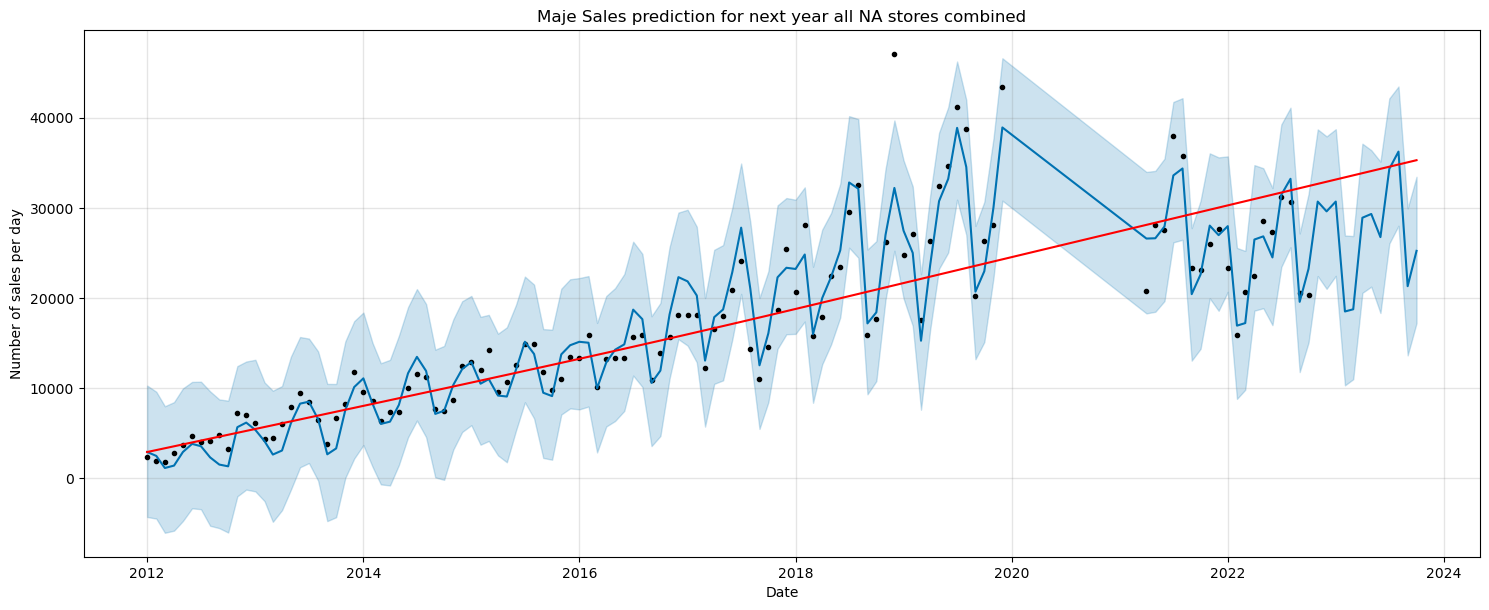

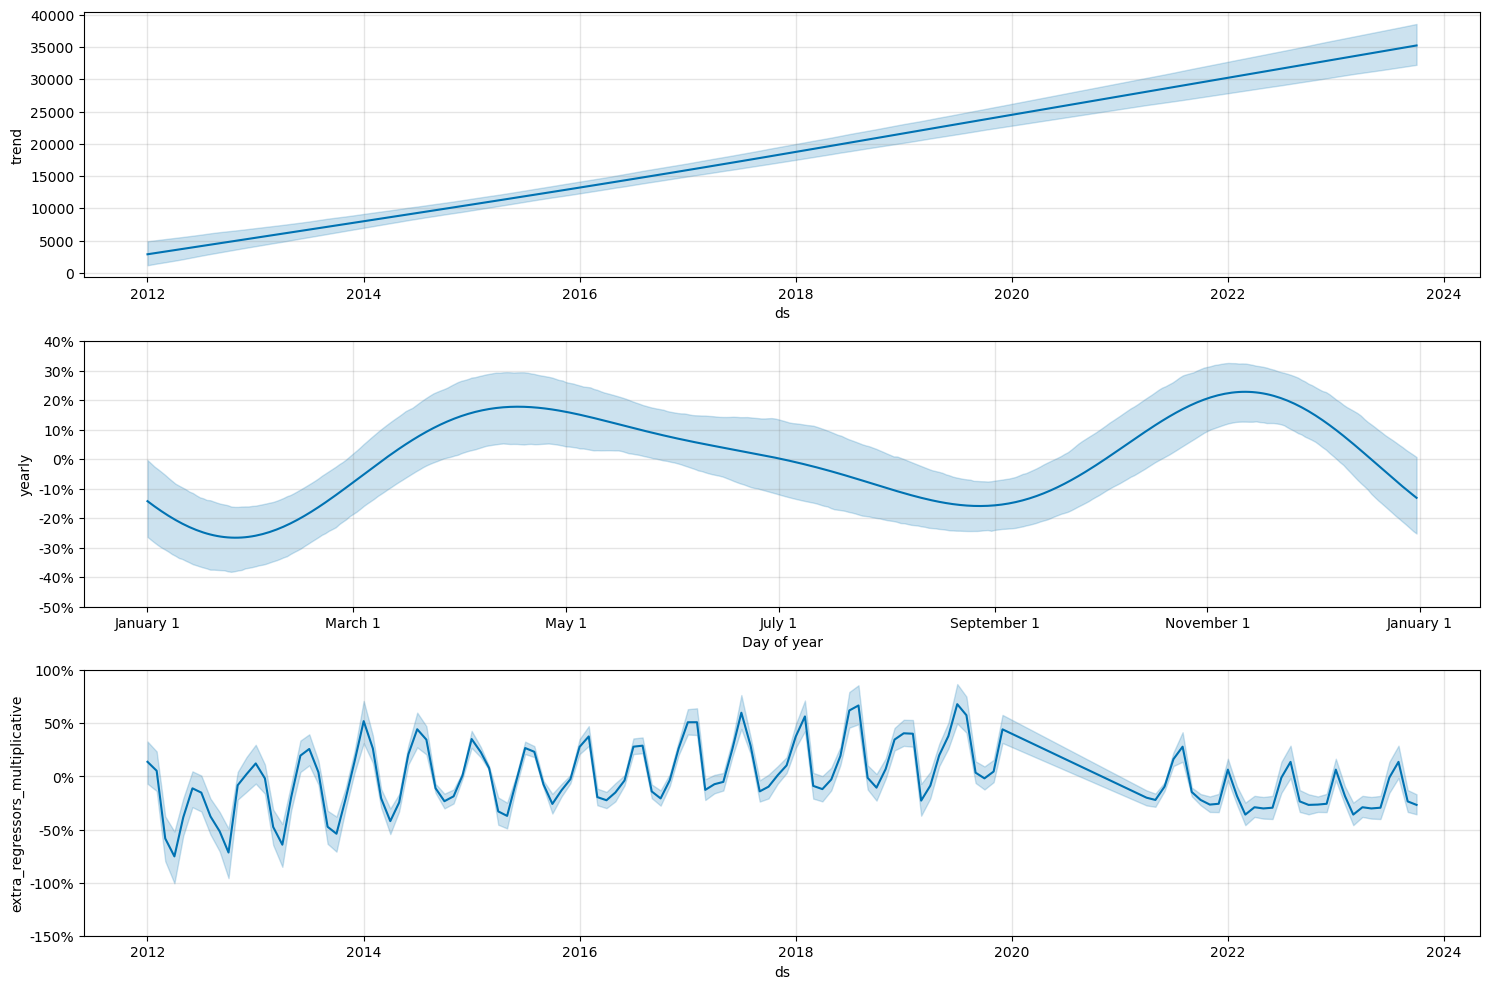

  regressor  regressor_mode     center  coef_lower      coef  coef_upper
0       cci  multiplicative  85.836522    0.004560  0.007419    0.010298
1     drate  multiplicative  43.065493    0.010809  0.015328    0.019601
2        un  multiplicative   5.272174   -0.111065 -0.056378   -0.004660


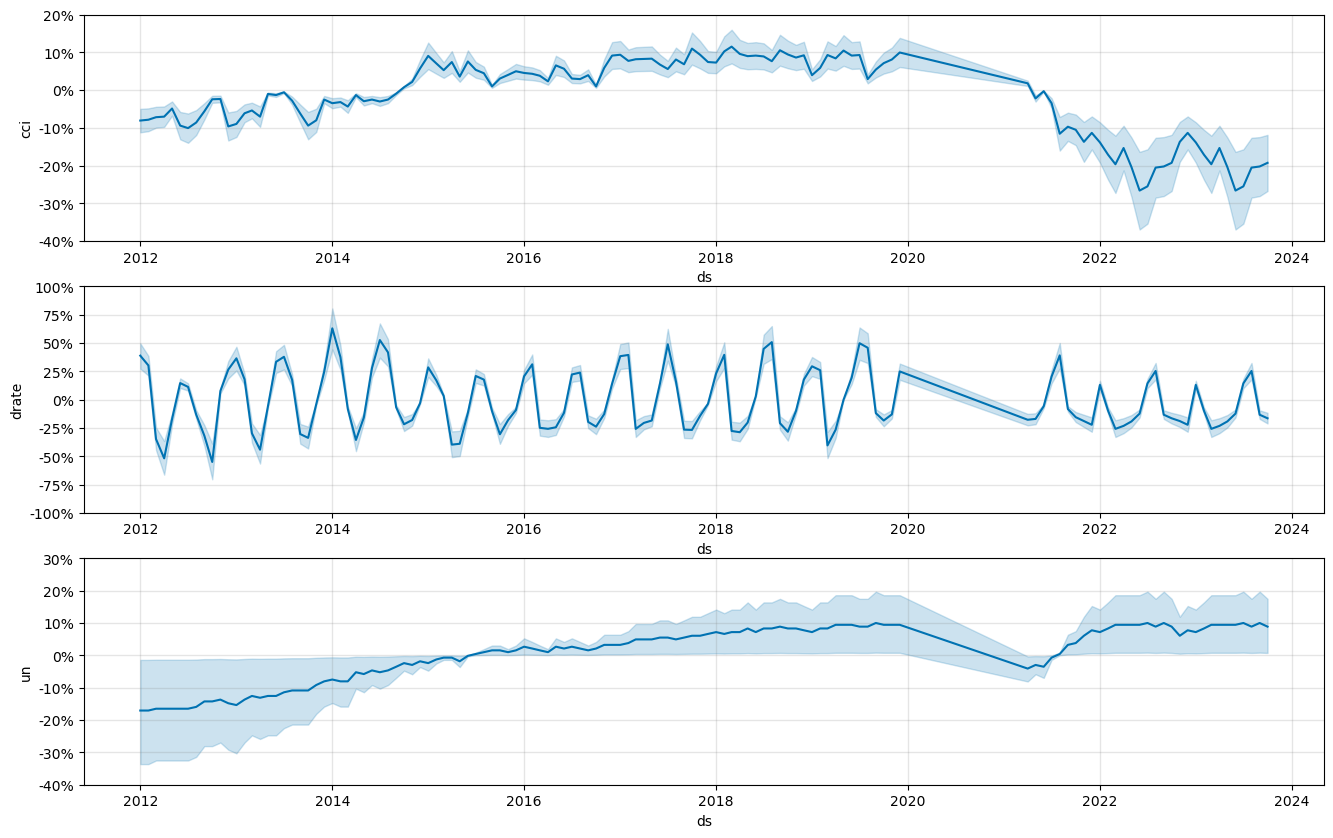

In [11]:
for brand,df in {'Maje':sales_maje}.items():#,'Maje':sales_maje}.items():
    y_axis_lim=None#(0,3000)
    x_axis_lim=None#['2016-01-01','2012-12-31']
    #---------------------------------------hyperparameters tuning-------------------------------------
    param_grid = {
                 'seasonality_prior_scale': [10.0, 1.0, 0.1,0.01]
                   ,'changepoint_prior_scale': [0.5,0.1, 0.01,0.001]#
#                     ,'changepoint_range':[0.8,0.85,0.9,0.95]
#                  ,'holidays_prior_scale':[10,1,0.1,0.01]
#                  ,'seasonality_mode': ['additive','multiplicative']
    }
    all_params = [dict(zip(param_grid.keys(), value))
                  for value in itertools.product(
                        *param_grid.values())]
    rmse_values= []
    all_metrics_df = pd.DataFrame()
    for params in all_params:
        model = Prophet(
                    growth='linear'
                    ,seasonality_mode='multiplicative'
                    ,yearly_seasonality=3
#                     ,weekly_seasonality=3
                    ,interval_width=0.99
#                    ,uncertainty_samples=1000 if brand =='Sandro' else 10000
#                     ,mcmc_samples=30
                    ,**params
#                     ,holidays=holidays
                   )
        if no_regressor != True:
            model.add_regressor('cci')
            model.add_regressor('drate')
            model.add_regressor('un')
#             model.add_regressor('part')
#             model.add_regressor('dgorder')
#             model.add_regressor('fed')

        model.fit(df)
        df_cv = cross_validation(model
                    ,horizon='180 days'
                    ,period='30 days'
                    ,initial='1095 days'
                    ,parallel='processes')
        df_p = performance_metrics(df_cv, rolling_window=1)
        all_metrics_df = pd.concat([all_metrics_df,df_p])
        rmse_values.append(df_p['rmse'].values[0])
        #saves the all combinations results

    results = pd.DataFrame(all_params)
#     results['rmse'] = rmse_values
    for col in all_metrics_df:
        results[col] = all_metrics_df[col].to_list()
    best_params = all_params[np.argmin(rmse_values)]
    print(best_params)
    #-----------------------------------------instantiating the model---------------------------------------
    model = Prophet(
                    growth='linear'
                    ,seasonality_mode='multiplicative'
                    ,yearly_seasonality=3
#                     ,weekly_seasonality=3
#                     ,seasonality_prior_scale=10
#                     ,changepoint_prior_scale=0.015 #if brand=='Sandro' else 0.05
                    ,interval_width=0.99
#                    ,uncertainty_samples=1000 if brand =='Sandro' else 10000
                    ,mcmc_samples=1000
                    ,**best_params
#                     ,holidays=holidays
                   )
    if no_regressor != True:        
        model.add_regressor('cci')
        model.add_regressor('drate')
        model.add_regressor('un')
#         model.add_regressor('part')
#         model.add_regressor('dgorder')
#         model.add_regressor('fed')

    #-----------------------------------------fitting the model---------------------------------------
    model.fit(df)

    future = model.make_future_dataframe(periods=0 * 1)#dataset is already duplicated a year into the future
    if no_regressor != True:
        future['cci'] = df['cci']
        future['drate'] = df['drate']
        future['un'] = df['un']
#         future['part'] = df['part']
#         future['dgorder'] = df['dgorder']
#         future['fed'] = df['fed']
        
    future.fillna(0,inplace=True)
    forecast = model.predict(future)
    forecast = forecast[forecast['ds']<='2023-10-01']
    chp_threshold=0.1#0.1
    fig = model.plot(forecast, xlabel='Date',
    ylabel=r'Number of sales per day', figsize = (15,6))
    add_changepoints_to_plot(fig.gca(), model, forecast,threshold=chp_threshold,cp_linestyle='--')
    plt.title(f'{brand} Sales prediction for next year all NA stores combined')

    if y_axis_lim:
        plt.ylim(y_axis_lim)
    if x_axis_lim:
        plt.xlim(pd.to_datetime(x_axis_lim))
    plt.show()

    #-----------------------------------------plotting seasonality---------------------------------------
    fig2 = model.plot_components(forecast, figsize = (15,10))
    # if x_axis_lim:
    #   plt.xlim(pd.to_datetime(x_axis_lim))
    plt.show()

    #----------------------------------printing and plotting extra regressors----------------------------
    if no_regressor != True:
        print(regressor_coefficients(model))

    #     print(pd.DataFrame({'holiday': model.train_holiday_names,
    #                 'effect': [first_non_zero(forecast, holiday)
    #                 for holiday in \
    #                 model.train_holiday_names]}))

        fig, axes = plt.subplots(
                                len(regressor_coefficients(model)),
                                figsize=(16, 10))
        for i, regressor in enumerate(
                                regressor_coefficients(model)['regressor']):
                                plot_forecast_component(model,
                                forecast,
                                regressor,
                                axes[i])
        plt.show()

In [12]:
results.sort_values(by=['rmse'],ascending=True).head(20)

seasonality_prior_scale  changepoint_prior_scale  horizon           mse  \
6                      1.00                    0.010 180 days  1.893672e+07   
10                     0.10                    0.010 180 days  1.934310e+07   
2                     10.00                    0.010 180 days  1.935526e+07   
3                     10.00                    0.001 180 days  2.003637e+07   
11                     0.10                    0.001 180 days  2.030178e+07   
14                     0.01                    0.010 180 days  2.036318e+07   
15                     0.01                    0.001 180 days  2.116286e+07   
7                      1.00                    0.001 180 days  2.172520e+07   
1                     10.00                    0.100 180 days  2.800059e+07   
5                      1.00                    0.100 180 days  2.830738e+07   
9                      0.10                    0.100 180 days  2.863043e+07   
13                     0.01                    0.100 180 days  3.130121e+07   
4                      1.00                    0.500 180 days  3.979614e+07   
0                     10.00                    0.500 180 days  4.017797e+07   
8                      0.10                    0.500 180 days  4.346882e+07   
12                     0.01                    0.500 180 days  8.365283e+07   

           rmse          mae      mape     mdape     smape  coverage  
6   4351.633969  2977.206540  0.134133  0.103012  0.133690  0.796690  
10  4398.079527  2983.120827  0.133784  0.105057  0.132677  0.799054  
2   4399.461366  3000.216493  0.135148  0.101552  0.134433  0.791962  
3   4476.200216  3042.390386  0.136744  0.105350  0.135665  0.784870  
11  4505.749435  3043.798325  0.136100  0.106283  0.134753  0.780142  
14  4512.557845  3092.373816  0.137800  0.121742  0.138069  0.820331  
15  4600.311272  3147.032877  0.139844  0.117949  0.140399  0.817967  
7   4661.029452  3151.494808  0.141515  0.105425  0.139247  0.763593  
1   5291.558243  3216.247297  0.146974  0.097316  0.138711  0.749409  
5   5320.468121  3228.054340  0.147225  0.097046  0.138823  0.749409  
9   5350.741490  3214.377347  0.145718  0.093142  0.136897  0.749409  
13  5594.748807  3498.436167  0.156618  0.114023  0.149634  0.773050  
4   6308.418203  3495.564143  0.159193  0.094679  0.141676  0.683215  
0   6338.609429  3518.724403  0.160553  0.098242  0.142920  0.685579  
8   6593.088726  3551.618909  0.160239  0.093808  0.141266  0.706856  
12  9146.192183  4444.911906  0.195906  0.111081  0.166047  0.749409

In [13]:
print(max(results['rmse']))
print(min(results['rmse']))

9146.192182531868
4351.633969149896
